# Analyzing NYC High School Data

## Introduction

New York City has published data on the SAT scores of students, along with additional demographic datasets - http://opendata.cityofnewyork.us/.

* ap_2010.csv -- Advanced Placement exam results for each high school. Passing AP exams can get you college credit in the US.
* class_size.csv -- class size information for each school in NYC.
* demographics.csv -- demographic information for each school.
* graduation.csv -- percentage of students who graduated, and other outcome information.
* hs_directory.csv -- a directory of high schools.
* sat_results.csv -- SAT scores for each high school in New York City.
* survey_all.txt -- data on surveys from all schools.
* survey_d75.txt -- data on surveys from New York City district 75.

## Reading in the data     

In [27]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Reading in the surveys

In [28]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Adding DBN columns

In [29]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Converting columns to numeric

In [30]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] \
+ data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condensing datasets

In [31]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Converting AP scores to numeric

In [32]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

## Combining the datasets

In [33]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Adding a school district column for mapping

In [34]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Finding correlations

In [35]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Correlation between SAT score and survey results

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
survey_corr = combined.corr()["sat_score"][data['survey'].columns].dropna()
print(survey_corr)

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


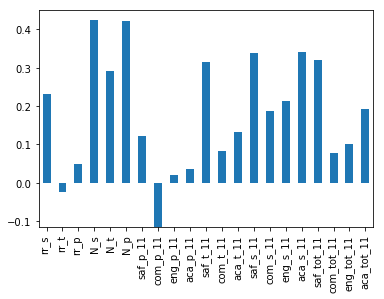

In [38]:
survey_corr.plot.bar()

### Observations

Based on the above bar chart of the 'r' correlation coeffecients of the SAT score and survey results, we can notice that there is high positive correlation (or 'r' value) between the SAT score and: 
1. The number of students/ teachers/ parents who participated in the survey.
2. The safety and respect score of the students/ teacher/ total.
3. The academic expectation of the students.

In [39]:
pandas.read_excel("2011 data files online/data_description.xls")

,2011 NYC School Survey Data Dictionary,Unnamed: 1
0,This data dictionary can be used with the scho...,NaN
1,NaN,NaN
2,Field Name,Field Description
3,dbn,School identification code (district borough n...
4,sch_type,"School type (Elementary, Middle, High, etc)"
5,location,School name
6,enrollment,Enrollment size
7,borough,Borough
8,principal,Principal name
9,studentsurvey,Only students in grades 6-12 partipate in the ...


## Scatter plot - safety score of students vs SAT score

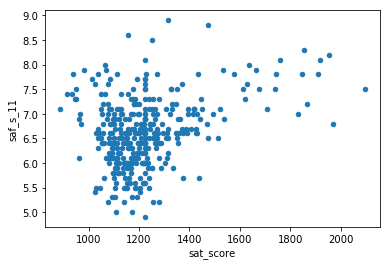

In [40]:
combined.plot.scatter('sat_score','saf_s_11')

### Observations

Based on the scatter plot above, we notice a dense cluster which thins out in atleast 2 different directions as the safety and SAT scores increase. This dense cluster is probably the reason for the high 'r' value, it lies between 5.5 and 7.0 of the safety score (y-axis),and 1000 and 1400 of the SAT score (x-axis). Although, this cluster does not provide a good direction, rather the regression line through this cluster would be parallel to the safety score (y-axis) with SAT scores (x-axis) in the 1100 - 1150 range.

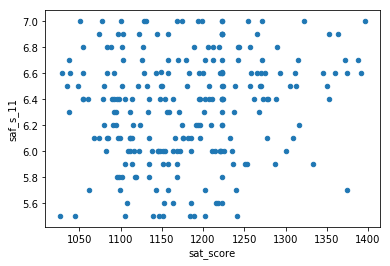

In [41]:
combined_zoomed = combined[((combined['sat_score']>=1000)&(combined['sat_score']<=1400))& \
                           ((combined['saf_s_11']>=5.5)&(combined['saf_s_11']<=7.0))]
combined_zoomed.plot.scatter('sat_score','saf_s_11')

### Observations

Nothing significant observed if we zoom in to the dense region of the scatter plot.

## Plotting safety scores on the NYC map

/Users/jeganram/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/jeganram/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/jeganram/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


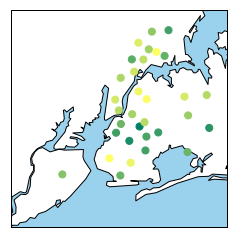

In [42]:
from mpl_toolkits.basemap import Basemap

m = Basemap(llcrnrlon=-74.256820, llcrnrlat=40.493640, urcrnrlon=-73.707503, urcrnrlat=40.912157, projection='merc', \
            resolution='h')
m.drawcoastlines()
m.drawmapboundary(fill_color='#9ad1ec')
m.drawrivers()
m.fillcontinents(color='white',lake_color='#9ad1ec')
dist_avg = combined.groupby('school_dist').agg(np.mean)
dist_avg.reset_index(inplace=True)
lat = dist_avg['lat'].tolist()
lon = dist_avg['lon'].tolist()
m.scatter(lon, lat, latlon=True, c=dist_avg['saf_s_11'], cmap='summer', zorder=2, s=50)
plt.show()

### Observations
The colormap above suggests that the safest schools based on safety score from students are in north of Brooklyn, east of Queens, Staten Island and lower Manhattan. The Bronx, upper Manhattan, south of Brooklyn and west of Queens seems to be the most unsafe.

## Analyzing correlation between race and SAT scores

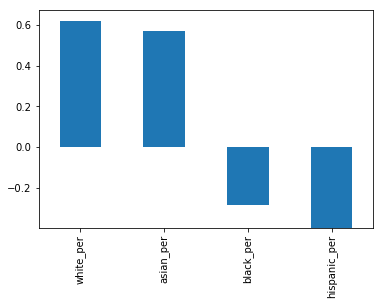

In [43]:
def sat_corr_bar_chart(columns):
    column_corr = combined.corr()["sat_score"][columns].dropna()
    column_corr.plot.bar()
    plt.show()
    return

sat_corr_bar_chart(['white_per','asian_per','black_per','hispanic_per'])

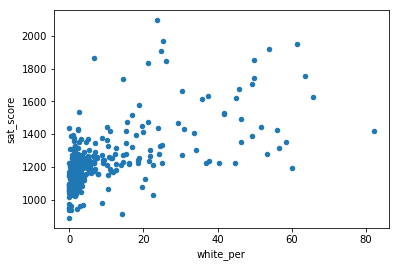

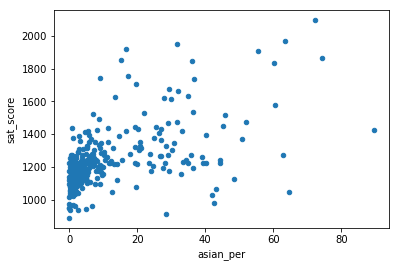

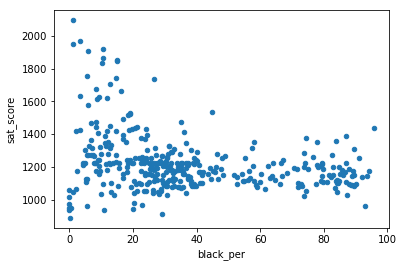

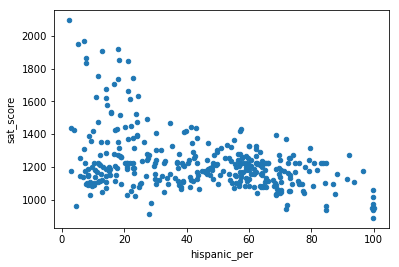

In [44]:
def scatter_plot(x,y):
    combined.plot.scatter(x,y)
    plt.show()
    return

races = ['white_per','asian_per','black_per','hispanic_per']

for race in races:
    scatter_plot(race,'sat_score')

### Observations
Based on the above correlation plots, there is a weak positive correlation between the SAT scores, and white_per and asian_per, this is somewhat expected. There is also a medium negative correlation between the SAT scores, and black_per and hispanic_per, this was expected as well. 

In [45]:
hispanic_schools = combined[combined['hispanic_per']>=95]
hispanic_schools['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Observations
Above schools have relatively high minority (non-white ethnicity) and economically disadvantaged students. They are catering to recent immigrants.

In [46]:
non_hispanic_high_sat_schools = combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
non_hispanic_high_sat_schools['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Observations
Above schools have relatively low minority and economically disadvantaged students. They are designated as technical and science schools, receiving relatively more funding. They require students to pass entrance exams for admissions.

## Analyzing correlations between gender and SAT scores

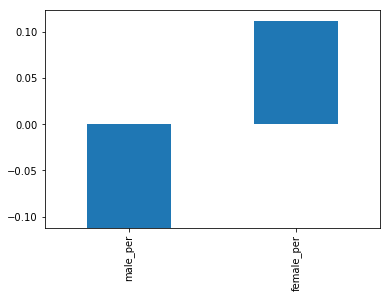

In [47]:
sat_corr_bar_chart(['male_per','female_per'])

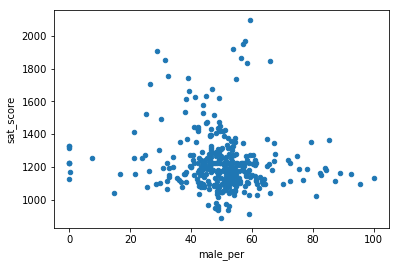

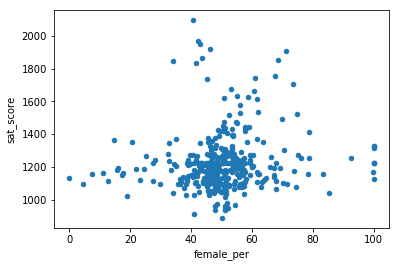

In [48]:
gender = ['male_per','female_per']

for item in gender:
    scatter_plot(item,'sat_score')

### Observations
There seems to be a weak negative correlation between SAT scores and male percentage, and a weak positive correlation between SAT scores and female percentage.

In [49]:
female_high_sat_schools = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
female_high_sat_schools['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Observations
Above are highly ranked liberal arts schools, and have highly competitive entrance exams to gain admissions.

## Analyzing correlation between AP test taker percentage and SAT scores

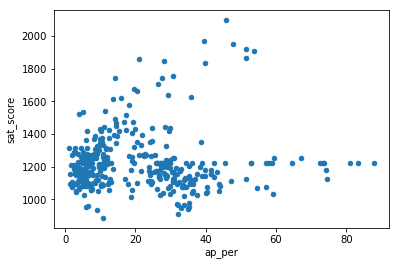

In [50]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']*100
scatter_plot('ap_per','sat_score')

### Observations
There is a weak positive correlation between AP test takers percentage and SAT scores. Not a strong correlation as one would expect.

## Correlation between class size and SAT score

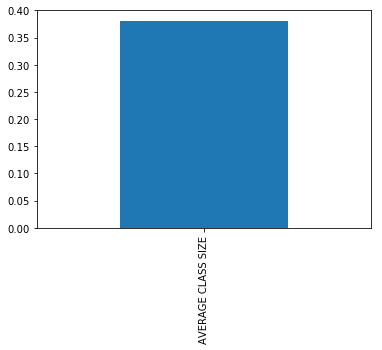

In [51]:
sat_corr_bar_chart(['AVERAGE CLASS SIZE'])

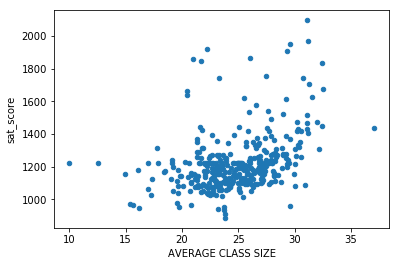

In [52]:
scatter_plot('AVERAGE CLASS SIZE','sat_score')

### Observations
There is weak positive correlation between SAT scores and average class size.

## Potential next steps
Figuring out the best area to live in based on school performance.

If we combine this with a property values dataset, we could find the cheapest place where there are good school.

Looking into the differences between parent, teacher, and student responses to surveys.

Assigning a score to schools based on sat_score and other attributes.